In [1]:
import os
import json
import warnings
import zipfile

import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import AnchorGenerator

from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib import patches as patches

from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')

In [5]:
with zipfile.ZipFile('Mask Wearing.v4-raw.coco.zip', 'r') as f:
  f.extractall('.')

In [6]:
for file in os.listdir('train'):
  filename = f'train/{file}'
  if file.endswith('.json'):
    print(filename)

train/_annotations.coco.json


In [7]:
# annotations = json.load(open('train/_annotations.coco.json'))

In [8]:
class COCOAnnotationUtils:

  def __init__(self, path):
    self.raw_annotations = json.load(open(path))
    self.image2id = {}
    self.id2annot = {}

    self._collect_image_ids()
    self._collect_image_annotations()

  def _collect_image_ids(self):
    for image_meta in self.raw_annotations['images']:
      try:
        name = image_meta['file_name']
        image_info = {
            'id': image_meta['id'],
            'height': float(image_meta['height']),
            'width': float(image_meta['width'])
        }
        self.image2id[name] = image_info
      except KeyError:
        print('Annotation structure is invalid')
        return
      except ValueError:
        print('Cant convert to float')
        return

  def _collect_image_annotations(self):
    for annot in self.raw_annotations['annotations']:
      image_id = annot['image_id']

      if image_id not in self.id2annot:
        self.id2annot[image_id] = []
      
      self.id2annot[image_id].append(
          {
              'area': float(annot['area']),
              'bbox': [float(b) for b in annot['bbox']],
              'iscrowd': float(annot['iscrowd'])
          }
      )

  def get_image_info(self, image_name):
    return self.image2id[image_name]

  def get_image_annotation(self, image_name):
    if image_name not in self.image2id:
      raise ValueError(f'No such image {image_name}')
    image_id = self.image2id[image_name]['id']
    image_annot = self.id2annot[image_id]
    return image_annot

coco_utils = COCOAnnotationUtils('train/_annotations.coco.json')

In [9]:
class ImageReshapeUtils:

  def __init__(self, height, width):
    self.height = height
    self.width = width

  def forward_reshape_image(self, image):
    return image.resize((self.width, self.height))

  def backward_reshape_image(self, image, size):
    return image.resize(size)

  def _forward_resize_bbox(self, bbox, image):
    x_scale = self.width / image.size[0]
    y_scale = self.height / image.size[1]
    return [
      bbox[0] * x_scale,
      bbox[1] * y_scale,
      bbox[2] * x_scale,
      bbox[3] * y_scale
    ]

  def _backward_resize_bbox(self, bbox, image):
    x_scale = image.size[0] / self.width
    y_scale = image.size[1] / self.height
    return [
      bbox[0] * x_scale,
      bbox[1] * y_scale,
      bbox[2] * x_scale,
      bbox[3] * y_scale
    ]

  def forward_reshape_annot(self, image, annot):
    scale_annot = []
    x_scale = self.width / image.size[0]
    y_scale = self.height / image.size[1]
    for a in annot:
      scale_annot.append({
          'area': a['area'] * x_scale * y_scale,
          'bbox': self._forward_resize_bbox(a['bbox'], image),
          'iscrowd': a['iscrowd']
      })
    return scale_annot

  def backward_reshape_annot(self, image, annot):
    restore_annot = []
    x_scale = self.width / image.size[0]
    y_scale = self.height / image.size[1]
    for a in annot:
      restore_annot.append({
          'area': a['area'] / x_scale / y_scale,
          'bbox': self._backward_resize_bbox(a['bbox'], image),
          'iscrowd': a['iscrowd']
      })
    return restore_annot

In [10]:
class MaskDetectionDataset(torch.utils.data.Dataset):

  def __init__(self, path, image_size=300, transforms=None):
    self.image_paths = []
    self.image_size = image_size
    self.annotation_utils = None
    self.reshape_utils = ImageReshapeUtils(self.image_size, self.image_size)
    if transforms is None:
      self.transforms = A.Compose([
        A.Normalize(),
        ToTensor()
      ])
    else:
      self.transforms = transforms

    if not path.endswith('/'):
      path = path + '/'
    for file in os.listdir(path):
      filepath = f'{path}{file}'
      if file.endswith('.json'):
        self.annotation_utils = COCOAnnotationUtils(f'{path}{file}')
      elif not file.endswith('.jpg'):
        continue
      else:
        self.image_paths.append(filepath)
    if self.annotation_utils is None:
      raise ValueError('Could not find annotation file')

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    original_image = Image.open(image_path)
    image_name = image_path.split('/')[-1]
    image_id = self.annotation_utils.get_image_info(image_name)['id']
    image_annot = self.annotation_utils.get_image_annotation(image_name)

    image_annot = self.reshape_utils.forward_reshape_annot(original_image, image_annot)
    image = self.reshape_utils.forward_reshape_image(original_image)

    area = []
    boxes = []
    labels = []
    iscrowd = []
    
    for annot in image_annot:
      box = annot['bbox']
      x0, y0 = box[0], box[1]
      x1, y1 = x0 + box[2], y0 + box[3]

      if x0 == x1 and y0 == y1:
        continue

      boxes.append([x0, y0, x1, y1])
      area.append(annot['area'])
      labels.append(1)
      iscrowd.append(annot['iscrowd'])

    target = {
        'area': torch.tensor(area, dtype=torch.float),
        'boxes': torch.tensor(boxes, dtype=torch.float),
        'labels': torch.ones((len(labels),), dtype=torch.long),
        'iscrowd': torch.tensor(iscrowd, dtype=torch.int),
        'image_id': torch.tensor([image_id])
    }

    image = np.array(image)
    image = self.transforms(image=image)['image']

    return image, target

  def __len__(self):
    return len(self.image_paths)

In [11]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [23]:
def train_epoch(model, loader, optimizer, scheduler, device):
  model.train()

  epoch_loss = 0

  for batch in tqdm_notebook(loader):
    images, targets = batch

    images_input = [image.to(device) for image in images]
    targets_input = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()

    loss_dict = model(images_input, targets_input)
    loss = sum([l for l in loss_dict.values()])
    loss.backward()

    epoch_loss += loss.detach().cpu().item()

    optimizer.step()
  scheduler.step()

  return epoch_loss / len(loader)

In [24]:
def get_model(num_classes):
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  backbone.out_channels = 1280

  anchor_generator = AnchorGenerator(
      sizes=((32, 64, 128, 256),),
      aspect_ratios=((0.5, 0.75, 1.0, 1.5, 2.0),)
  )

  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
      featmap_names=['0'],
      output_size=7,
      sampling_ratio=2
  )
  
  model = torchvision.models.detection.FasterRCNN(
      backbone,
      num_classes=num_classes,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )

  return model

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_dataset = MaskDetectionDataset('train', image_size=300)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, collate_fn=collate_fn)

model = get_model(2)
# model = torchvision.models.detection.ssd300_vgg16(num_classes=2, trainable_backbone_layers=True, pretrained_backbone=True)
model.to(device)

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

cuda


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [34]:
for e in range(10):
  train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
  print(e + 1, train_loss)

  0%|          | 0/35 [00:00<?, ?it/s]

1 0.652303340605327


  0%|          | 0/35 [00:00<?, ?it/s]

2 0.5509830261979785


  0%|          | 0/35 [00:00<?, ?it/s]

3 0.4891511993748801


  0%|          | 0/35 [00:00<?, ?it/s]

4 0.4547535857983998


  0%|          | 0/35 [00:00<?, ?it/s]

5 0.4332639992237091


  0%|          | 0/35 [00:00<?, ?it/s]

6 0.41767625723566326


  0%|          | 0/35 [00:00<?, ?it/s]

7 0.4015512811286109


  0%|          | 0/35 [00:00<?, ?it/s]

8 0.3864453741482326


  0%|          | 0/35 [00:00<?, ?it/s]

9 0.37971623965672086


  0%|          | 0/35 [00:00<?, ?it/s]

10 0.3710877350398472


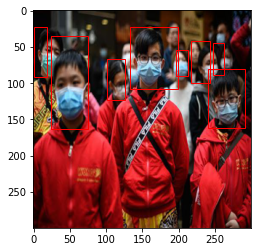

In [35]:
model.eval()

test_image = train_dataset[2]

test_image_input = [test_image[0].to(device)]
with torch.no_grad():
  raw_predict = model(test_image_input)[0]
  best_objects = torchvision.ops.nms(raw_predict['boxes'], raw_predict['scores'], iou_threshold=0.05)
  best_boxes = raw_predict['boxes'][best_objects].detach().cpu().numpy()


test_image_numpy = test_image[0].detach().cpu().numpy()

test_image_numpy *= torch.stack([
  torch.full((300, 300), 0.229),
  torch.full((300, 300), 0.224), 
  torch.full((300, 300), 0.225)
], dim=0).numpy()

test_image_numpy += torch.stack([
  torch.full((300, 300), 0.485),
   torch.full((300, 300), 0.456), 
   torch.full((300, 300), 0.406)
], dim=0).numpy()

test_image_numpy = test_image_numpy.transpose(1, 2, 0)
plt.imshow(test_image_numpy)

for best_box in best_boxes:
  rect = patches.Rectangle((best_box[0], best_box[1]), best_box[2] - best_box[0], best_box[3] - best_box[1],
                          linewidth=1, edgecolor='r', facecolor='none')
  plt.gca().add_patch(rect)
plt.show()

(1033, 675) (300, 300) (1033, 675)
[{'area': 1935.0, 'bbox': [170.0, 227.0, 43.0, 45.0], 'iscrowd': 0.0}, {'area': 17182.0, 'bbox': [392.0, 174.0, 121.0, 142.0], 'iscrowd': 0.0}]
[{'area': 249.757986447241, 'bbox': [49.37076476282672, 100.88888888888889, 12.487899322362052, 20.0], 'iscrowd': 0.0}, {'area': 2217.7476605356565, 'bbox': [113.84317521781219, 77.33333333333333, 35.14036786060019, 63.11111111111111], 'iscrowd': 0.0}]
[{'area': 1934.9999999999998, 'bbox': [170.0, 227.0, 43.0, 45.0], 'iscrowd': 0.0}, {'area': 17182.0, 'bbox': [391.99999999999994, 174.0, 121.0, 142.0], 'iscrowd': 0.0}]


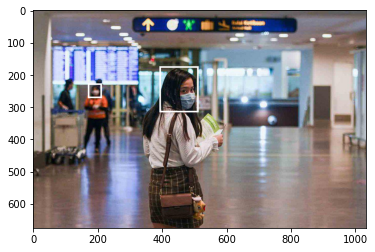

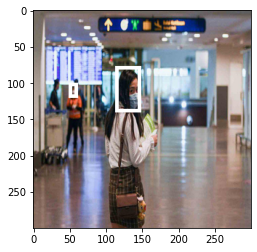

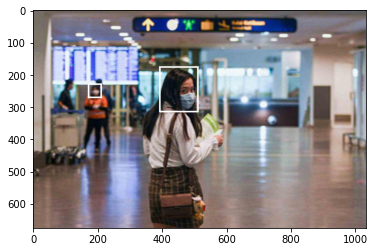

In [ ]:
reshape_utils = ImageReshapeUtils(300, 300)
test_image = Image.open('train/0002526673_jpg.rf.a13de6faa0e2e5250d913ccf27b4c769.jpg')
test_image_annot = coco_utils.get_image_annotation('0002526673_jpg.rf.a13de6faa0e2e5250d913ccf27b4c769.jpg')

small_image = reshape_utils.forward_reshape_image(test_image)
restore_image = reshape_utils.backward_reshape_image(small_image, test_image.size)
print(test_image.size, small_image.size, restore_image.size)

small_annot = reshape_utils.forward_reshape_annot(test_image, test_image_annot)
restore_annot = reshape_utils.backward_reshape_annot(test_image, small_annot)
print(test_image_annot)
print(small_annot)
print(restore_annot)

draw = ImageDraw.Draw(test_image)
for a in test_image_annot:
  bbox = a['bbox']
  x, y = bbox[0], bbox[1]
  dx, dy = bbox[2], bbox[3]
  draw.rectangle([x, y, x + dx, y + dy], width=5)
plt.imshow(test_image)
plt.show()

draw = ImageDraw.Draw(small_image)
for a in small_annot:
  bbox = a['bbox']
  x, y = bbox[0], bbox[1]
  dx, dy = bbox[2], bbox[3]
  draw.rectangle([x, y, x + dx, y + dy], width=5)
plt.imshow(small_image)
plt.show()


draw = ImageDraw.Draw(restore_image)
for a in restore_annot:
  bbox = a['bbox']
  x, y = bbox[0], bbox[1]
  dx, dy = bbox[2], bbox[3]
  draw.rectangle([x, y, x + dx, y + dy], width=5)
plt.imshow(restore_image)
plt.show()